In [1]:
# %%capture
!pip install pandas trimesh scipy matplotlib
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"
!pip install celluloid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 5.7 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-4flr776m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-4flr776m
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 3087ab7f62b5d581a133e54849d462f37fdf4c2d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.5-cp310-cp310-linux_x86_64.whl size=56908581 sha256=6ad0ca83360019d92ccedc84f37d03580663fedf2255a733afba9bc680820d5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ysjo0v82/wheels/dd/74/cc/b9266c863f19026f796e59a04e1cd9eb3754474a52ce1b66ce
  

In [2]:
!git clone https://github.com/B3aRrrr/M8MachineLearningLabsAndHomeworks.git

Cloning into 'M8MachineLearningLabsAndHomeworks'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 322 (delta 83), reused 155 (delta 58), pack-reused 122
Receiving objects: 100% (322/322), 54.35 MiB | 26.14 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [27]:
!pip3 install 'git+https://github.com/marian42/mesh_to_sdf.git'

  Cloning https://github.com/marian42/mesh_to_sdf.git to /tmp/pip-req-build-qs7jybcl
  Running command git clone --filter=blob:none --quiet https://github.com/marian42/mesh_to_sdf.git /tmp/pip-req-build-qs7jybcl
  Resolved https://github.com/marian42/mesh_to_sdf.git to commit 66036a747e82e7129f6afc74c5325d676a322114
  Preparing metadata (setup.py) ... done
  Using cached pyrender-0.1.45-py3-none-any.whl (1.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mesh-to-sdf: filename=mesh_to_sdf-0.0.14-py3-none-any.whl size=14485 sha256=f4b015dca7245944ad4d6ccf63a3efa632f05ce09681d28f57f0a4d13f29a69a
  Stored in directory: /tmp/pip-ephem-wheel-cache-u4nniig7/wheels/7b/8b/98/5e5cf11cfb0b345c711b37d5b63ead35b4d513ba7b81e11e7f
  Created wheel 

In [28]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes

# render
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    PointLights
)

from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# trimesh lib imports
import trimesh

In [29]:
from tqdm import tqdm_notebook
from celluloid import Camera
from matplotlib import animation
from IPython.display import HTML

Провести эксперимент с деформацией моделей. В данном случае в качестве исходного приблежения взять модель сферы, а в качестве целевой модели выступает собственная модель.

In [30]:
path_to_model = os.path.join(
    os.getcwd(),
    'M8MachineLearningLabsAndHomeworks',
    'Sem3',
    '3DML',
    '7GTVT1P06RUB6N7EQH8SICVVS.obj'
)


### Подготовка моделей

In [36]:

# Trimesh .obj model
jess_trimesh = trimesh.load(path_to_model)

if isinstance(jess_trimesh, trimesh.Scene):
    bunny_trimesh = jess_trimesh.dump(concatenate=True)

jess_trimesh.vertices -= jess_trimesh.center_mass
scaling = 2 / jess_trimesh.scale
jess_trimesh.apply_scale(scaling=scaling)

# Jess mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# textures = Textures(verts_rgb=verts_rgb.to(device))
textures=TexturesVertex(verts_features=verts_rgb.to(device))

# Create a meshes object for the Jess.
jess_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

Импорт модели сферы

In [37]:
# Trimesh sphere .obj model
trimesh_sphere = trimesh.primitives.Sphere(subdivisions= 4)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))
sphere_mesh.textures=TexturesVertex(verts_features=verts_rgb.to(device))

In [38]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [39]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024,
    blur_radius=0,
    faces_per_pixel=1,
)

# We can add a directional light in the scene.
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
        )
)

# Select the viewpoint using spherical angles
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the bunny providing the values of R and T.
image_bunny = phong_renderer(meshes_world=bunny_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_bunny = image_bunny.cpu().numpy()

Параметры оптимизационного процесса

In [34]:

# Number of optimization steps
Niter = 3000
# Weight for the chamfer loss
w_chamfer = 1.0
# Weight for mesh edge loss
w_edge = 1.0
# Weight for mesh normal consistency
w_normal = 0.01
# Weight for mesh laplacian smoothing
w_laplacian = 0.1
# Plot period for the losses
plot_period = 50

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

**Градиентный спуск**

В цикле происходит градиентный спуск по функции потерь, представляющей из себя взвешенную сумму функций ошибок регуляризаторов.

Для более лучшего понимания происходящего была реализована анимация.

In [42]:

loop = tqdm_notebook(range(Niter))

fig = plt.figure()
camera = Camera(fig)

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)

    # We sample 5k points from the surface of each mesh
    sample_trg = sample_points_from_meshes(jess_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)

    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)

    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)

    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)

    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer.item())
    edge_losses.append(loss_edge.item())
    normal_losses.append(loss_normal.item())
    laplacian_losses.append(loss_laplacian.item())

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the bunny providing the values of R and T.
        image_jess = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_jess = image_jess.detach().cpu().numpy()

        plt.imshow(image_jess.squeeze())
        plt.grid(False)
        camera.snap()

    # Optimization step
    loss.backward()
    optimizer.step()

plt.close()

# Create animation
anim = camera.animate()

# Inline display
HTML(anim.to_html5_video())

<ipython-input-42-8d4f9e4798a5>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(Niter))


  0%|          | 0/3000 [00:00<?, ?it/s]

**Изменения функций потерь и регуляризаторов**

Text(0.5, 1.0, 'Loss vs iterations')

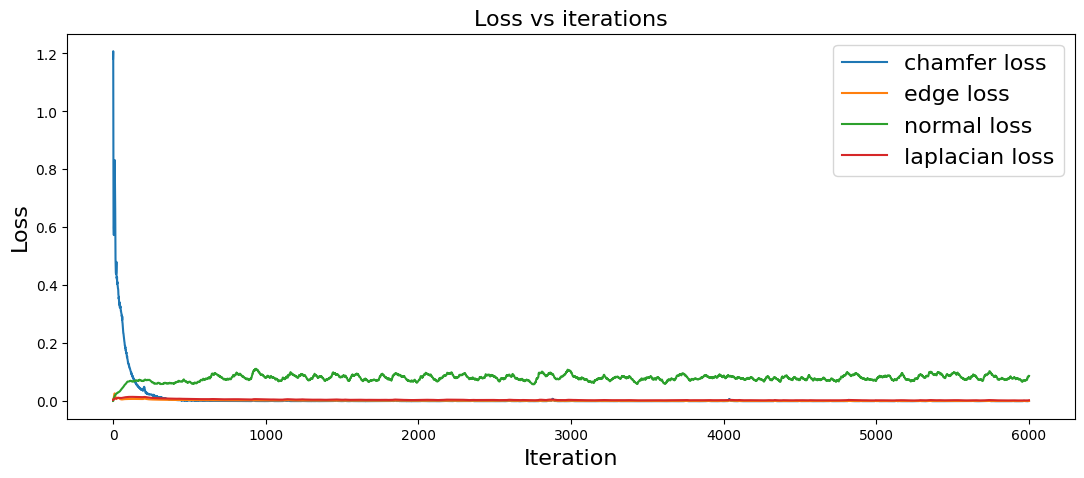

In [43]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")